In [1]:
# ********** User Inputs ****************************************************************** #
file_name = 'BenKnight/message.json'
timezone = 'America/New_York' # set local timezone
anniversary_date = '2017-07-12'

# Import Statements

In [3]:
# ********** Import Statements ************************************************************ #
import pandas as pd
import numpy as np
import json
import pytz
import re

import sys
import matplotlib.pyplot as plt
import nltk

import plotly
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
import plotly.offline
plotly.offline.init_notebook_mode(connected=True) # run at the start of every notebook to use plotly

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# Program Sketch

**Goal**: To gather inferential statistics from Facebook messenger data in a systematic manner, like sentiment analysis, occurrence of specific words, length / quantity / complexity of conversations / messages / words per user, extraction of a personal ‘lexicon’, and potential utilization of machine learning to craft an “AI-built conversation” between the two parties.

**Super High Level**: JSON goes in, neat stuff gets found, data comes out.

**High Level Task List**:
1. Pull messenger data from Facebook and convert into a DataFrame.
2. Clean up the DataFrame so it can be interacted with easily.
3. Parse DataFrame to show interesting inferences, like:
    * frequency of words used over time.
    * personal vocabulary between two people (relationship lingua Franca #thanksnick)
    * what does a 'conversation' look like?
    * artificial AI-generated "conversation" between both people.
4. Visualize the interesting data in pixel/scarf-esque patterns.
5. Export the data in ~some format~ so it can feed into KnitForKnat.

---
**Functions Needed**:
1. Parsing Data
    * Setting the local timezone
    * Pulling the names
2. Splicing Data Sets
    * By user  (separate one person from another, perhaps group chats in future, use \*args)
    * By time  (hour, day, week, month, year for analysis, comparison)
    * By value (...)
3. Counts/Calculations (combined + per person):
    * How many words / messages / conversations were there?
    * How many times did person X say word W? (count)
    * How often did person X say word W compared to person Y? (ratio)
    * How often did person X say word W in respect to the words they say? (respective ratio)


# Functions

In [4]:
# ********** Functions ******************************************************************** #
# Convert file name of FB Conversation json to a DataFrame.
def convert_filename_to_df(file_name):
    # open the data
    with open(file_name) as f: #
        data = json.load(f)
        
    # pull out messages for dataframe conversion
    messages = [x for x in data['messages']]
    
    df = pd.DataFrame(messages)
    return df

In [5]:
# Set to local timezone of user
def utc_to_local(utc_dt):
    local_tz = pytz.timezone(timezone)
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(local_tz)
    return local_tz.normalize(local_dt)

In [6]:
# 0 means 'before start of dating'
# 1 means 'first dating year'
# 2 means 'second dat.......

def determine_dating_year(date_col):
    # get the date we want, add 4 bc it's being weird
    dateyear_start = utc_to_local(pd.to_datetime(anniversary_date) + pd.DateOffset(hours=4))
    
    # subtract single day from all dates
    new_col = date_col - dateyear_start
    
    # convert all Timedeltas to day precision and only pull the number of days
    new_col2 = new_col.apply(lambda x: x.astype('timedelta64[D]').item().days) 
    
    return (new_col2//365)+1

In [7]:
# Clean up the dataframe in order to parse going forward
def clean_dataframe(df, year_start='default'):
    # sort by oldest message
    df.sort('timestamp_ms', inplace=True)

    # set all content to lowercase for easier parsing going forward
    df['content'] = df['content'].str.lower()
    df['content'].fillna(value='', inplace=True)
    
    # convert unixtime to datetime and map to local timezone!
    df['date'] = pd.to_datetime(df['timestamp_ms'], unit='ms')
    df['date'] = map(utc_to_local, df['date'])
    
    # create a column that pulls out the year
    if year_start == 'default':
        df['date_year'] = df['date'].apply(lambda x: x.year)
    elif year_start == 'anniversary':
        df['date_year'] = determine_dating_year(df['date'])
    
    df['word_count'] = df['content'].apply(lambda x: len(re.findall(r'\w+', x)))
    
    # rename columns to be prettier :)
    df.columns = [' '.join(map(lambda i:i.capitalize(), x.replace('_', ' ').split())) for x in df.columns]
    return df

In [8]:
def person(name):
    # this assumes you've already created chat_df
    unique_names = chat_df['Sender Name'].unique()
    if name in unique_names:
        return chat_df[chat_df['Sender Name'] == name]
    else:
        print name, 'isn\'t in the DataFrame. \nTry one of these:', ', '.join(unique_names.astype(str))

# Parsing the Messenger Data

In [9]:
# Let's parse our data.
chat_df_raw = convert_filename_to_df(file_name)
chat_df = clean_dataframe(chat_df_raw, year_start='anniversary')

# Grouping By

In [10]:
chat_df.to_csv('BenKnightConvo.csv', encoding='utf-8')

In [11]:
# Great. Now we have a working DataFrame.
# What's the date range we're working with?
print chat_df['Date'].min().date(), 'to', chat_df['Date'].max().date()

2017-07-06 to 2018-07-30


In [12]:
s = {x:'count' for x in chat_df.columns-['Word Count']}
s['Word Count'] = 'sum'

s

{u'Audio Files': 'count',
 u'Call Duration': 'count',
 u'Content': 'count',
 'Date': 'count',
 'Date Year': 'count',
 u'Gifs': 'count',
 u'Missed': 'count',
 u'Photos': 'count',
 u'Reactions': 'count',
 u'Sender Name': 'count',
 u'Share': 'count',
 u'Sticker': 'count',
 u'Timestamp Ms': 'count',
 u'Type': 'count',
 u'Videos': 'count',
 'Word Count': 'sum'}

In [13]:
# Grouping by dating year AND name.
chat_df.groupby(['Date Year', 'Sender Name']).agg(s).sort_index(axis=1)

Audio Files  Call Duration  Content   Date  Date Year  \
Date Year Sender Name                                                          
0         Ben Knight             0              0      219    219        219   
          Cassie Beth            0              0      361    361        361   
1         Ben Knight             0              4    13621  13621      13621   
          Cassie Beth            6             13    26158  26158      26158   
2         Ben Knight             0              0      949    949        949   
          Cassie Beth            5              1     1819   1819       1819   

                       Gifs  Missed  Photos  Reactions  Sender Name  Share  \
Date Year Sender Name                                                        
0         Ben Knight      0       0       0          0          219      0   
          Cassie Beth     0       0       8          0          361      5   
1         Ben Knight    139       4     231         91        13621    115   
          Cassie Beth   140       9    1714         11        26158    268   
2         Ben Knight      2       0      35         11          949     17   
          Cassie Beth     8       0     153          1         1819     17   

                       Sticker  Timestamp Ms   Type  Videos  Word Count  
Date Year Sender Name                                                    
0         Ben Knight         0           219    219       0        3244  
          Cassie Beth        2           361    361       0        6069  
1         Ben Knight       141         13621  13621       5      109548  
          Cassie Beth      157         26158  26158     106      228105  
2         Ben Knight        16           949    949       0        6972  
          Cassie Beth       14          1819   1819       7       13147

In [14]:
# Grouping by name
chat_df.groupby(['Sender Name']).agg(s).sort_index(axis=1)

,Audio Files,Call Duration,Content,Date,Date Year,Gifs,Missed,Photos,Reactions,Sender Name,Share,Sticker,Timestamp Ms,Type,Videos,Word Count
Sender Name,,,,,,,,,,,,,,,,
Ben Knight,0,4,14789,14789,14789,141,4,266,102,14789,132,157,14789,14789,5,119764
Cassie Beth,11,14,28338,28338,28338,148,9,1875,12,28338,290,173,28338,28338,113,247321


In [15]:
# Grouping by dating year
chat_df.groupby(['Date Year']).agg(s).sort_index(axis=1)

,Audio Files,Call Duration,Content,Date,Date Year,Gifs,Missed,Photos,Reactions,Sender Name,Share,Sticker,Timestamp Ms,Type,Videos,Word Count
Date Year,,,,,,,,,,,,,,,,
0,0,0,580,580,580,0,0,8,0,580,5,2,580,580,0,9313
1,6,17,39779,39779,39779,279,13,1945,102,39779,383,298,39779,39779,111,337653
2,5,1,2768,2768,2768,10,0,188,12,2768,34,30,2768,2768,7,20119


In [16]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

In [17]:
def analyze(df, name):
    neutral, negative, positive = 0, 0, 0

    for index, sentence in enumerate(df['Content']):
        if re.match(r'^[\w]', sentence) is None:
            continue
        scores = sentiment_analyzer.polarity_scores(sentence)
        scores.pop('compound', None)

        maxAttribute = max(scores, key=lambda k: scores[k])

        if maxAttribute == "neu":
            neutral += 1
        elif maxAttribute == "neg":
            negative += 1
        else:
            positive += 1

    total = neutral + negative + positive
    print("Negative: {0}% | Neutral: {1}% | Positive: {2}%".format(
        negative*100/total, neutral*100/total, positive*100/total))

    labels = 'Neutral', 'Negative', 'Positive'
    sizes = [neutral, negative, positive]
    colors = ['#00bcd7', '#F57C00', '#CDDC39']

    # Plot
    plt.pie(sizes, labels=labels, colors=colors,
            autopct='%1.1f%%', startangle=140)

    plt.axis('equal')
    plt.title("Sentiment Analysis - Chat with {0}".format(name.capitalize()))
    plt.show()

Negative: 2% | Neutral: 78% | Positive: 18%


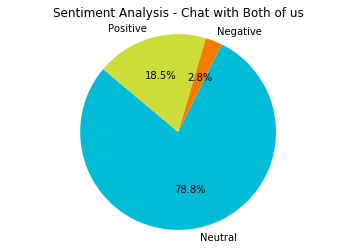

In [18]:
analyze(chat_df,"Both of Us")

Negative: 2% | Neutral: 81% | Positive: 15%


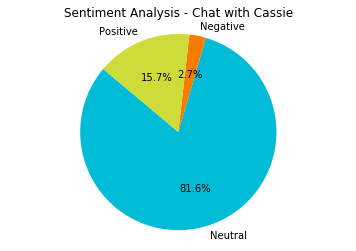

In [19]:
analyze(person('Cassie Beth'),"Cassie")

Negative: 2% | Neutral: 73% | Positive: 23%


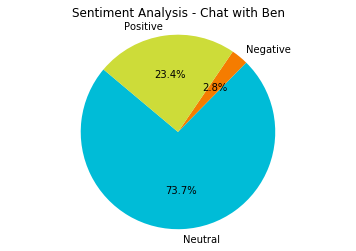

In [20]:
analyze(person('Ben Knight'),"Ben")

In [21]:
person('Ben Knight')['Word Count']

43124     5
43120     8
43116     5
43113     9
43110     4
43108    10
43106    12
43104     5
43101     2
43100    16
43095    33
43094     8
43092    10
43089    41
43087     1
...
46     1
45     4
43     5
41     3
39     8
36     4
29    22
28    16
23     6
20     3
18     6
12    10
10     4
8      0
6      9
Name: Word Count, Length: 14789, dtype: int64

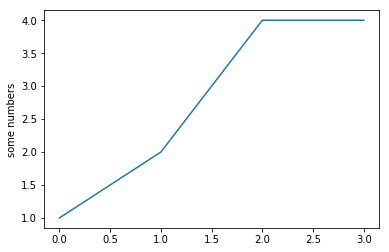

In [22]:
plt.plot([1,2,4,4])
plt.ylabel('some numbers')
plt.show()

In [23]:
plt.xkcd()

In [24]:
chat_df.index = chat_df['Date']#.groupby(['Date'].mo)

In [25]:
test_df = chat_df.groupby([chat_df['Sender Name'], chat_df.index.year, chat_df.index.month])['Word Count'].sum().reset_index()

test_df['Date'] = test_df['level_1'].map(str) + "-" + test_df['level_2'].map(str)

In [28]:
trace1 = go.Scatter(
    x=test_df['Date'],
    y=test_df[test_df['Sender Name']=='Ben Knight']['Word Count'],
    name = 'Ben')

In [29]:
trace2 = go.Scatter(
    x=test_df['Date'],
    y=test_df[test_df['Sender Name']=='Cassie Beth']['Word Count'],
    name='Cassie')

In [35]:
fig = go.Figure(data=data, layout={'title':'Word Count by Month of Year One'})

In [36]:
plotly.offline.iplot(fig)

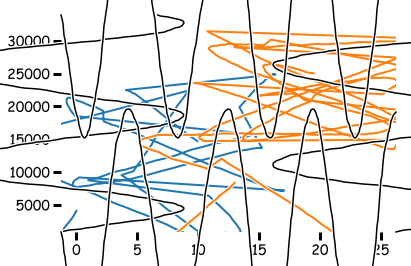

In [46]:
plt.plot(test_df[test_df['Sender Name']=='Ben Knight']['Word Count'])
plt.plot(test_df[test_df['Sender Name']=='Cassie Beth']['Word Count'])

plt.show()

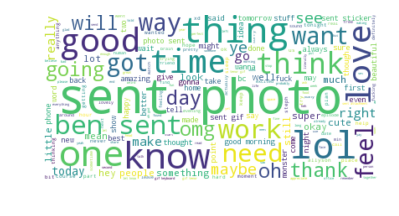

In [47]:
text = ' '.join(x for x in chat_df['Content'])
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
# do quantile
# word clouds per month

In [49]:
test_df

,Sender Name,level_1,level_2,Word Count,Date
0,Ben Knight,2017,7,4091,2017-7
1,Ben Knight,2017,8,2320,2017-8
2,Ben Knight,2017,9,4120,2017-9
3,Ben Knight,2017,10,10540,2017-10
4,Ben Knight,2017,11,8792,2017-11
5,Ben Knight,2017,12,10728,2017-12
6,Ben Knight,2018,1,13188,2018-1
7,Ben Knight,2018,2,9136,2018-2
8,Ben Knight,2018,3,11786,2018-3
9,Ben Knight,2018,4,15230,2018-4


In [50]:
chat_df

,Audio Files,Call Duration,Content,Gifs,Missed,Photos,Reactions,Sender Name,Share,Sticker,Timestamp Ms,Type,Videos,Date,Date Year,Word Count
Date,,,,,,,,,,,,,,,,
2017-07-06 21:36:17.411000-04:00,NaN,NaN,oh lololol,NaN,NaN,NaN,NaN,Cassie Beth,NaN,NaN,1499391377411,Generic,NaN,2017-07-06 21:36:17.411000-04:00,0,2
2017-07-06 21:36:25.048000-04:00,NaN,NaN,"apparently, we already did this before, lol.",NaN,NaN,NaN,NaN,Cassie Beth,NaN,NaN,1499391385048,Generic,NaN,2017-07-06 21:36:25.048000-04:00,0,7
2017-07-06 21:37:17.703000-04:00,NaN,NaN,this is so delightfully serendipitous,NaN,NaN,NaN,NaN,Ben Knight,NaN,NaN,1499391437703,Generic,NaN,2017-07-06 21:37:17.703000-04:00,0,5
2017-07-06 21:37:35.100000-04:00,NaN,NaN,"funny enough, scrolling up through our short c...",NaN,NaN,NaN,NaN,Cassie Beth,NaN,NaN,1499391455100,Generic,NaN,2017-07-06 21:37:35.100000-04:00,0,16
2017-07-06 21:37:37.820000-04:00,NaN,NaN,and not just my cat.,NaN,NaN,NaN,NaN,Cassie Beth,NaN,NaN,1499391457820,Generic,NaN,2017-07-06 21:37:37.820000-04:00,0,5
2017-07-06 21:37:49-04:00,NaN,NaN,"cats, dogs, horses, rabbits, guinea pigs, you ...",NaN,NaN,NaN,NaN,Cassie Beth,NaN,NaN,1499391469000,Generic,NaN,2017-07-06 21:37:49-04:00,0,9
2017-07-06 21:38:07.098000-04:00,NaN,NaN,omg the wildlife world has conspired against you,NaN,NaN,NaN,NaN,Ben Knight,NaN,NaN,1499391487098,Generic,NaN,2017-07-06 21:38:07.098000-04:00,0,8
2017-07-06 21:38:13.920000-04:00,NaN,NaN,"i still /have/ the cat, but to wrap up a 5 yea...",NaN,NaN,NaN,NaN,Cassie Beth,NaN,NaN,1499391493920,Generic,NaN,2017-07-06 21:38:13.920000-04:00,0,18
2017-07-06 21:38:27.767000-04:00,NaN,NaN,"and i'm a fiber artist, so very much so.",NaN,NaN,NaN,NaN,Cassie Beth,NaN,NaN,1499391507767,Generic,NaN,2017-07-06 21:38:27.767000-04:00,0,10


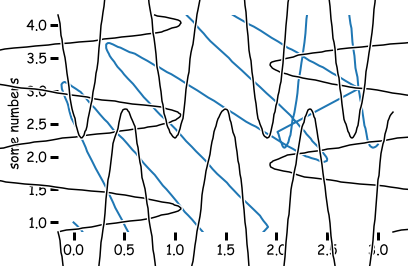

In [51]:
plt.plot([1,2,4,4])
plt.ylabel('some numbers')
plt.show()